<div style="text-align: center"> 

# From Cellular Automata to MED-NCA
### John Kalkhof*, Mirko Konstantin*
#### Darmstadt University of Technology, Karolinenplatz 5, 64289 Darmstadt, Germany 

</div>

<p align="center">
    <img src="Tutorial/Images/input_normal.png" height="80" />
    <img src="Tutorial/Images/inference_normal.gif" height="80" />
    <img src="Tutorial/Images/inference_normal_variance.gif" height="80" />
    <img src="Tutorial/Images/input_erase.png" height="80" />
    <img src="Tutorial/Images/inference_erase.gif" height="80" />
    <img src="Tutorial/Images/inference_erase_variance.gif" height="80" />
</p>

>Medical image segmentation relies heavily on UNet and Transformer-based architectures with millions of parameters. While these methods are effective, they require significant infrastructure. This is particularly problematic in low-resource environments and hinders equal opportunities in healthcare. This problem is particularly pronounced in low- and middle-income countries, primary care facilities, and conflict zones, where such methods could potentially bring great benefits to the treatment of patients. We have introduced **MED-NCA** a set of lightweight Neural Cellular Automata based models, that *with merely 10k-70k parameters can achieve accuracy on par with a UNet with more than 500 times more parameters*. This is possible due to its repeated locally interacting one-cell model.


*Equal Contribution

---

## Introduction Cellular Automata: On the example of Game of Life <a name="introductionCA"></a>

In the late 1960s, British mathematician John Conway created a virtual mathematical machine that operates on a two-dimensional grid of square cells. Each cell can exist in one of two states: alive or dead. The states of all cells are updated simultaneously at discrete time intervals.[1]

The living cells at time t + 1 are determined by those at time t based on the following local rules:

1. A live cell with two or three live neighbors will survive to the next generation; otherwise, it will change its state to dead.
2. If a dead cell has exactly three neighbors, the cell will change its state to alive in the next generation. [2]

With these simple rules, the Game of Life can generate patterns of astonishing complexity. Indeed, it is known to be Turing universal. [3]

In the code example below, we illustrate Conway's Game of Life and show how the local rules are applied to the grid of cells. 

<span style="color:green"><em>
To visualize the results, we used a visualization tool with several features, such as the ability to press play to run or pause the simulation. This visualization scheme will also be used throughout the rest of this tutorial. 
</em></span>.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import display, HTML

def update(frameNum, img, grid, N):
    newGrid = grid.copy()
    for i in range(N):
        for j in range(N):
            #Number of neighbors
            num_neighbors = int((grid[i, (j-1)%N] + grid[i, (j+1)%N] +
                                 grid[(i-1)%N, j] + grid[(i+1)%N, j] +
                                 grid[(i-1)%N, (j-1)%N] + grid[(i-1)%N, (j+1)%N] +
                                 grid[(i+1)%N, (j-1)%N] + grid[(i+1)%N, (j+1)%N])/255)
            #The rule
            if grid[i, j] == 255:
                if (num_neighbors < 2) or (num_neighbors > 3):
                    newGrid[i, j] = 0
            else:
                if num_neighbors == 3:
                    newGrid[i, j] = 255
    img.set_data(newGrid)
    grid[:] = newGrid[:]
    return img,

def create_game_of_life_animation():
    N = 10
    updateInterval = 500

    grid = np.zeros((N, N))

    # Add a glider
    glider = np.array([[0, 0, 255],
                       [255, 0, 255],
                       [0, 255, 255]])

    grid[1:4, 1:4] = glider

    fig, ax = plt.subplots()
    ax.axis('off')
    img = ax.imshow(grid, interpolation='nearest')

    ani = animation.FuncAnimation(fig, update, fargs=(img, grid, N),
                                  frames=40,
                                  interval=updateInterval,
                                  blit=True)

    # Display the animation in the notebook
    display(HTML(ani.to_jshtml()))

    plt.close(fig)

# Call the function to create and display the animation
create_game_of_life_animation()


## Limitations CA

Although Cellular Automata (CA) have the potential to generate complex behavior, the process of crafting the necessary rules is challenging. Designing these rules is difficult because it is nearly impossible to predict how small adjustments in the local rules will impact the CA's behavior over extended periods. This unpredictability makes it hard to fine-tune the system to achieve desired outcomes, limiting the practical application of CAs in modeling complex systems.

## Introduction NCA

The advent of Neural Cellular Automata (NCAs) offers a promising solution to the challenge of manually crafting rules for Cellular Automata. While NCAs still operate based on local rules, they differ from traditional Cellular Automata by using a neural network to automatically learn these rules rather than relying on handcrafted designs. This approach enables NCAs to discover rules that can produce the desired behavior through training, thus overcoming the difficulties associated with predicting and defining complex, effective rules manually.

The figure below illustrates the architecture of the NCA used in our M3D-NCA architecture [6]. Unlike traditional Cellular Automata, where cell states are typically binary ("alive" or "dead"), NCAs use a higher-dimensional representation of cell states, with a dimensionality set as a hyperparameter. In this example, the cell states are 16-dimensional, where additional state channels are referred to as hidden channels.

<div>
<img src="src/images/backbone_model_M3DNCA.png" width="400"/>
</div>

The pipeline begins with the perceptive step. Here, filters are applied to the cells to obtain vector representations. Commonly used filters include the Sobel filter in both the x and y directions, as well as the identity filter. These filtered vectors capture the local environment around each cell and are then passed to a neural network, which applies the current update rule for each cell based on these inputs.

##### When working with NCAs, there are three core concepts that are essential to understand:

- **Fire Rate:** In each iteration, an NCA applies a mask to the grid, determining which cells are updated during that iteration. This mask is generated by setting each cell to be active with a certain probability, known as the fire rate. The fire rate controls the likelihood that any given cell will be updated in an iteration.

- **Perception Range:** NCAs rely on local communication, meaning each cell interacts only with its neighboring cells. The term "neighbor" here refers to the cells within a specific receptive field, which can be set as a hyperparameter called the perception range. This range defines how many neighboring cells are considered when updating a given cell's state.

- **Steps:** Since information in an NCA propagates locally and takes time to spread across the entire grid, the final outcome of the system depends on the number of iterations, or steps, that are executed. The number of steps determines how long the NCA runs and can be set as a hyperparameter, influencing the complexity and completeness of the generated patterns.

Together, these concepts—fire rate, perception range, and steps—form the foundation for understanding and effectively utilizing NCAs.

## Growing NCA

In 2020, Mordvintsev et al. [4] introduced a version of Neural Cellular Automata (NCA) capable of growing a desired shape from a single cell. This method, known as Growing NCA, involves iteratively applying a learned rule, beginning with just one alive cell, until the target shape is fully formed. Remarkably, the behavior of Growing NCAs is robust, maintaining the final shape even as the NCA continues to update. Below, we provide a code example demonstrating Growing NCA by growing a lizard shape from a single pixel.

In [ ]:
import sys
import os
import torch
import numpy as np
sys.path.append(os.path.abspath('Tutorial/Tutorial_GrowingNCA/lib'))

import utils
from utils import mat_distance
from CAModel import CAModel
from utils_vis import to_rgb, make_seed

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import display, HTML


model_path     = 'Tutorial/Tutorial_GrowingNCA/models/growing_nca.pth'
_map_shape     = (72,72)
CHANNEL_N      = 16
CELL_FIRE_RATE = 0.5
steps          = 200
device         = torch.device("cpu")
_map           = make_seed(_map_shape, CHANNEL_N)


model = CAModel(CHANNEL_N, CELL_FIRE_RATE, device).to(device)
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))


output       = model(torch.from_numpy(_map.reshape([1,_map_shape[0],_map_shape[1],CHANNEL_N]).astype(np.float32)), 1)
_init_map    = to_rgb(output.detach().numpy()[0])
inference_np = [_init_map]


for step in range(steps):
    output = model(output, 1)
    inference_np.append(to_rgb(output.detach().numpy()[0]))
    
    

def create_growing_nca_animation():
    fig, ax = plt.subplots()

    # Create the animation for the inference steps
    img = ax.imshow(inference_np[0]) 
    ax.set_title('Growing NCA')
    ax.axis('off')

    def update(step):
        img.set_data(inference_np[step])
        return [img]

    ani = animation.FuncAnimation(fig, update, frames=len(inference_np), blit=True, repeat=True)

    # Instead of plt.show(), display the animation in the notebook
    display(HTML(ani.to_jshtml()))

    plt.close()



# Call the function to create and display the animation
create_growing_nca_animation()

## Limitations NCA
NCAs face several limitations due to their iterative nature. They require a substantial number of forward passes, which leads to high VRAM demands. Additionally, the local communication between cells results in slow information propagation, as it takes considerable time for information to traverse the entire grid. Training NCAs is also challenging, largely due to their sensitivity to hyperparameters and the lack of intuitive understanding of their behavior, making it difficult to fine-tune the models effectively.

## Introduction MED-NCA

<div>
<img src="src/images/model_MedNCA.png" width="600"/>
</div>

Med-NCA [5,6] is an end-to-end training pipeline for high-resolution image segmentation. Traditional NCAs face high VRAM demands and convergence difficulties when working with large medical images. Med-NCA addresses these limitations through a two-step segmentation process:
- **Global Information Propagation:** The first step of Med-NCA is to downscale the input image, allowing the first NCA to efficiently capture and propagate global information across the entire image with a smaller number of steps.
- **High-Resolution Patch-based Training:** The secon step is to upscale the hidden channels to the size of the original resolution. Now we replace the coarse representation of the input image with the according high-resolution counterpart. Since we would now run back into the high-vram requirement issue, we use patches of the high-res image during training. The second NCA now combines the coarse global knowledge of the first NCA, with the high-resolution information. *Interestingly while we do train on patches, the model generalizes well enough to perform inference on the full image.* 

**Key Advantages**

- **Efficient VRAM Usage:** Med-NCA’s multi-level design drastically reduces VRAM requirements, making it suitable for deployment on low-resource devices like a Raspberry Pi or a smartphone [7].
- **Robust and Scalable:** The model is inherently robust to variations in image scale, shape, and translation, and performs consistently across different medical imaging conditions [5].
- **Superior Performance:** Med-NCA outperforms traditional UNet models in segmentation tasks, achieving higher Dice scores with a model that is 500 times smaller [5,6].

### Load Pretrained MED-NCA: 2D Hippocampus Segmentation
In this section, we'll begin exploring Med-NCA inference using a trained model for 2D hippocampus segmentation. We will conduct various robustness experiments to evaluate the model's performance under different conditions.

*If you're interested in training a Med-NCA model from scratch, please refer to our other Jupyter notebooks, which provide detailed instructions and are not covered in this tutorial.*


In [1]:
#### LOAD PRETRAINED MED-NCA: 2D Hippocampus Segmentation

import torch
import random
from src.datasets.Nii_Gz_Dataset_3D import Dataset_NiiGz_3D
from src.models.Model_BackboneNCA import BackboneNCA
from src.losses.LossFunctions import DiceBCELoss
from src.utils.Experiment import Experiment
from src.agents.Agent_Med_NCA import Agent_Med_NCA
export TF_ENABLE_ONEDNN_OPTS=0

config = [{
    'img_path': r"",
    'label_path': r"",
    'model_path': r'Tutorial/Tutorial_MedNCA_Hippocampus',
    'device':"cuda:0",
    'unlock_CPU': True,
    # Optimizer
    'lr': 16e-4,
    'lr_gamma': 0.9999,
    'betas': (0.5, 0.5),
    # Training
    'save_interval': 10,
    'evaluate_interval': 10,
    'n_epoch': 1500,
    'batch_size': 40,
    # Model
    'channel_n': 32,        # Number of CA state channels
    'inference_steps': 16,
    'cell_fire_rate': 0.5,
    'input_channels': 1,
    'output_channels': 1,
    'hidden_size': 128,
    'train_model':1,
    'keep_original_scale':True,
    # Data
    'input_size': [(16, 16), (64, 64)],
    'data_split': [0.7, 0, 0.3], 
}
]

dataset = Dataset_NiiGz_3D(slice=2)
device = torch.device(config[0]['device'])
ca1 = BackboneNCA(config[0]['channel_n'], config[0]['cell_fire_rate'], device, hidden_size=config[0]['hidden_size'], input_channels=config[0]['input_channels']).to(device)
ca2 = BackboneNCA(config[0]['channel_n'], config[0]['cell_fire_rate'], device, hidden_size=config[0]['hidden_size'], input_channels=config[0]['input_channels']).to(device)
ca = [ca1, ca2]
agent = Agent_Med_NCA(ca)
exp = Experiment(config, dataset, ca, agent)
dataset.set_experiment(exp)
exp.set_model_state('test')
data_loader = torch.utils.data.DataLoader(dataset, shuffle=True, batch_size=exp.get_from_config('batch_size'))

2024-08-17 11:50:31.913036: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-17 11:50:31.933968: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-17 11:50:31.933991: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-17 11:50:31.934007: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-17 11:50:31.938380: I tensorflow/core/platform/cpu_feature_g

Tutorial/Tutorial_MedNCA_Hippocampus/data_split.dt
Tutorial/Tutorial_MedNCA_Hippocampus/models/epoch_1500
Reload State 1500


### Standard inference
Let's begin by examining the standard inference process of Med-NCA. Thanks to its iterative approach, this process allows us to visualize how the model gradually builds its final segmentation. As you observe the step-by-step progression, you'll notice the switch from the NCA operating on the coarse image after 16 steps to the second NCA refining the results on the high-resolution image. This transition reveals the underlying process of Med-NCA as it refines its final prediction.

Input image saved as input.png
Inference GIF saved as inference.gif


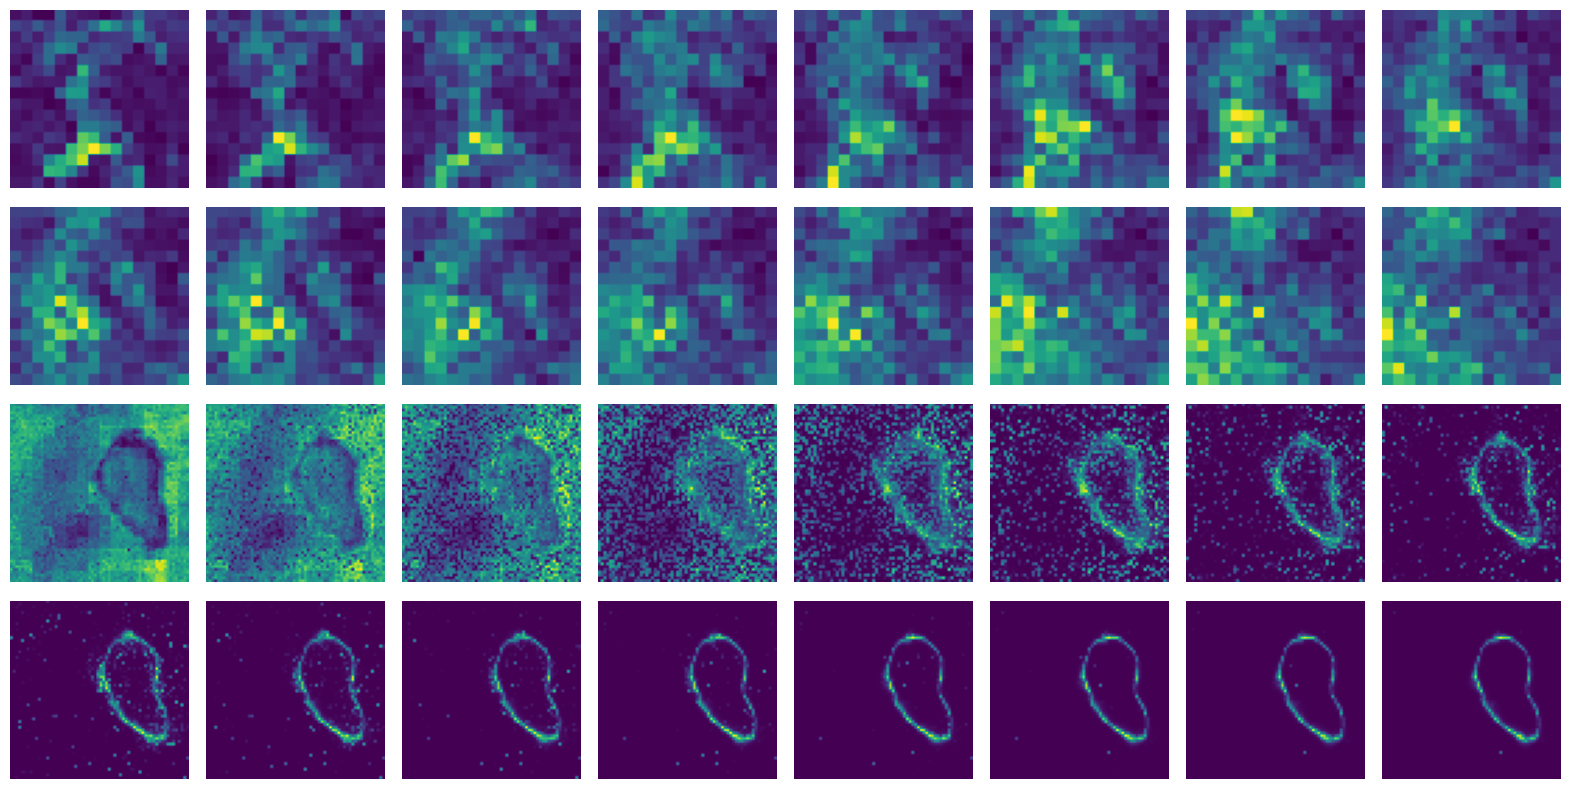

In [4]:
agent.visualizeInference(sample=12) # sample = Selection of the slice of the 3D MRI scan

### Robustness Experiment 1: Erase
In this experiment, we'll explore how Med-NCA handles scenarios where portions of the image are erased, testing the model's ability to cope with missing information.
Feel free to adjust the erased regions yourself to gain a deeper understanding of how effectively NCAs can counteract such perturbations. 
Additionally, if you run the experiment multiple times with the same input, you'll notice slight variations in the output due to the random activation of cells.


Input image saved as input.png
Inference GIF saved as inference.gif


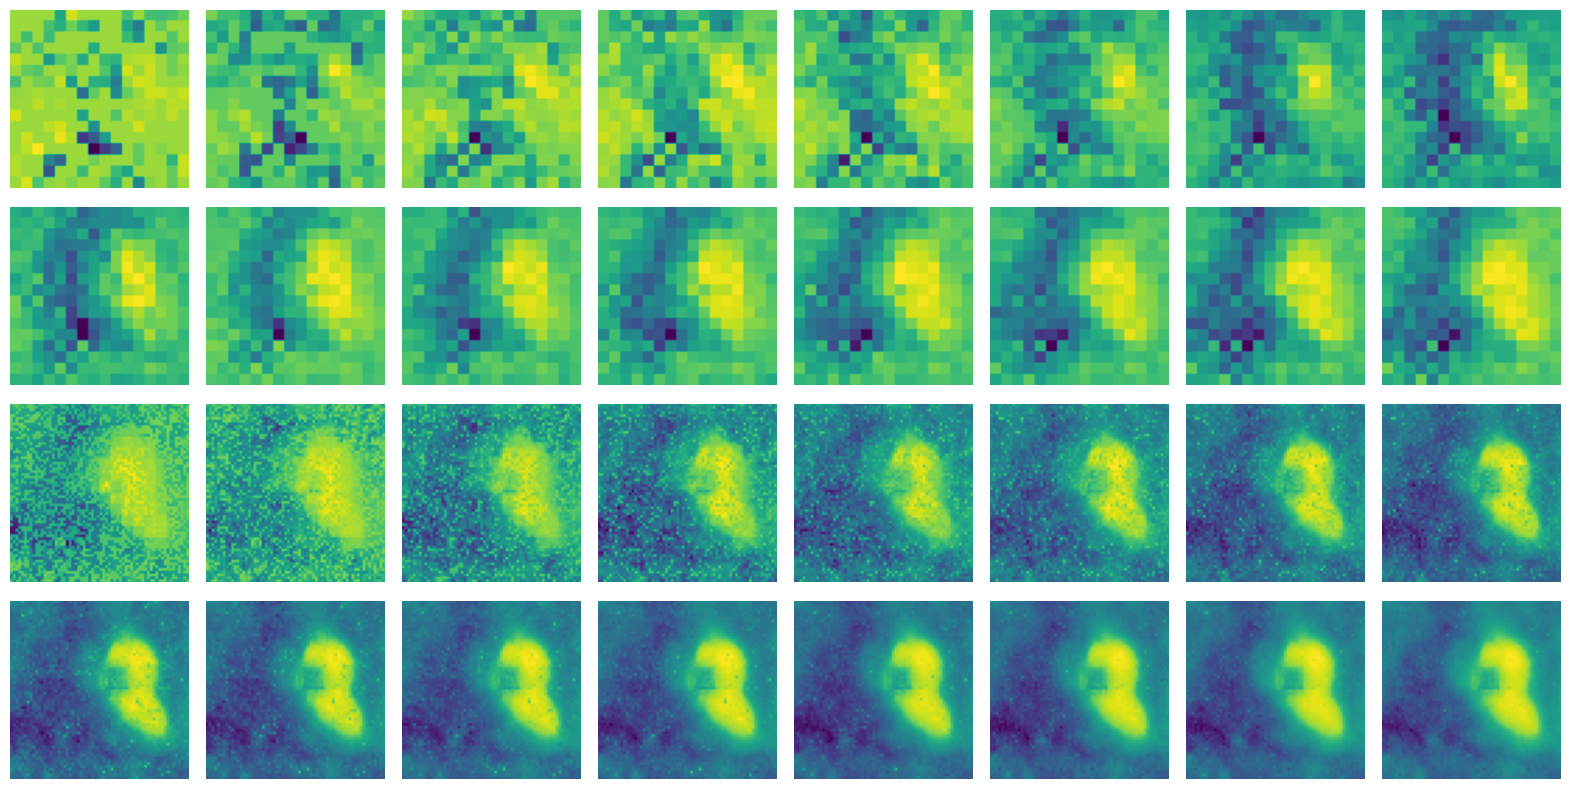

In [3]:
region = [24,32, # erase x1 to x2
         34,42] # erase y1 to y2
agent.visualizeInference(sample=12, erase=region)

### Robustness Experiment 2: Torchio Augmentations - Ghosting
Now, let's explore how effectively Med-NCA handles ghosting artifacts in the image. This experiment will help us assess the model's robustness to such perturbations.

Feel free to adjust the artifacts yourself to get a better understanding how well NCAs can counteract these disturbances and maintain accurate segmentation.

In [ ]:
import torchio as tio
torch.manual_seed(100)
artifact = tio.transforms.RandomGhosting(num_ghosts=4, axes=0, intensity=1.2)
#artifact = tio.transforms.RandomSpike(num_spikes=4, intensity=0.6)
agent.visualizeInference(sample=12, artifact=artifact)

### Variance Visualisation:
The inherent randomness of the NCA activations leads to slight variations in the predictions with each forward run. These variations can be used to visualize areas of high variance. In our work on “M3D-NCA”, we have exploited this property to develop a qualitative metric that helps to ensure the accuracy of the predictions. In our recent MICCAI publication, we have taken this concept even further and used these variations for unsupervised fine-tuning to effectively counteract domain shifts [7].

Let us now repeat the two experiments, this time focusing on the display of variance across multiple runs. As you observe the results, you’ll notice that, particularly in the erasure experiment, the region affected by the artifact also exhibits high variance. This highlights how areas of high variance in the model’s predictions correspond to regions with perturbations.

Input image saved as input.png
Inference GIF saved as inference.gif


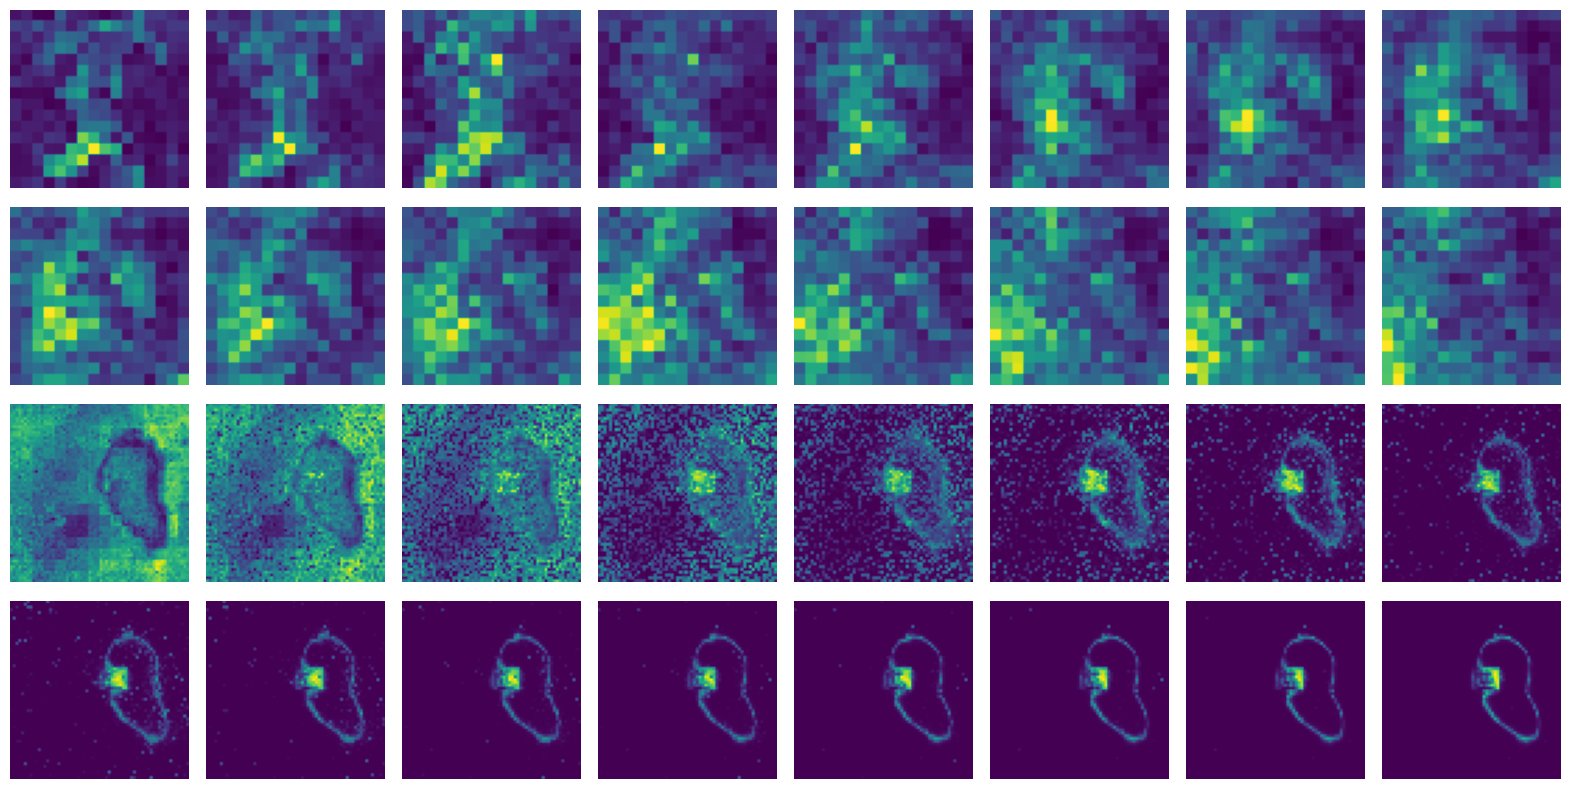

In [5]:
region = [24,32, # erase x1 to x2
         34,42] # erase y1 to y2
agent.visualizeInference(sample=12, erase=region, compute_variance=True)

In [ ]:
import torchio as tio
torch.manual_seed(100)
artifact = tio.transforms.RandomGhosting(num_ghosts=4, axes=0, intensity=1.2)
#artifact = tio.transforms.RandomSpike(num_spikes=4, intensity=0.6)
agent.visualizeInference(sample=12, artifact=artifact, compute_variance=True)

## What comes next?

NCAs hold great promise, particularly in resource-constrained environments where bringing advanced medical AI to the edge is crucial. While MED-NCA has already shown its strengths in image segmentation and registration, there's still a lot of unexplored potential. With some adaptation, MED-NCA could be extended to tasks such as classification and detection, opening up new avenues for research and application. 

## References

[1] ADAMATZKY, Andrew (Hg.). Game of life cellular automata. London: Springer, 2010.

[2] SCHULMAN, L. S.; SEIDEN, P. E. Statistical mechanics of a dynamical system based on Conway's Game of Life. Journal of Statistical Physics, 1978, 19. Jg., S. 293-314.

[3] BEER, Randall D. Autopoiesis and cognition in the game of life. Artificial Life, 2004, 10. Jg., Nr. 3, S. 309-326.

[4] Mordvintsev, et al., "Growing Neural Cellular Automata", Distill, 2020.

[5] Kalkhof, J., González, C., & Mukhopadhyay, A. (2023, June). Med-nca: Robust and lightweight segmentation with neural cellular automata. In International Conference on Information Processing in Medical Imaging (pp. 705-716). Cham: Springer Nature Switzerland.

[6] Kalkhof, John, and Anirban Mukhopadhyay. "M3D-NCA: Robust 3D Segmentation with Built-In Quality Control." International Conference on Medical Image Computing and Computer-Assisted Intervention. Cham: Springer Nature Switzerland, 2023.

[7] Kalkhof, J., Ranem, A., & Mukhopadhyay, A. (2024). Unsupervised Training of Neural Cellular Automata on Edge Devices.